A unified comparison of **Difference-in-Differences**, **Synthetic Control**, and **Synthetic Difference-in-Differences** — when each method works, when it fails, and why SynthDiD offers the best of both worlds.

In policy evaluation, we often want to estimate the causal effect of an intervention (a law, a program, a shock) on a treated unit (a state, a firm, a country) by comparing its post-treatment trajectory to a suitable **counterfactual**: what would have happened without the treatment?

Three leading methods construct this counterfactual in fundamentally different ways:

1. **Difference-in-Differences (DiD)** — uses the *average* change in control units as the counterfactual, assuming **parallel trends**.
2. **Synthetic Control (SC)** — constructs a *weighted combination* of control units that matches the treated unit's pre-treatment trajectory, assuming the treated unit lies in the **convex hull** of controls.
3. **Synthetic Difference-in-Differences (SynthDiD)** — combines the strengths of both: data-driven unit weights (like SC) with an intercept adjustment (like DiD), plus time weights that focus on the most informative pre-treatment periods.

[Arkhangelsky et al. (2021)](https://doi.org/10.1257/aer.20190159) showed that all three methods can be written as special cases of a **single weighted regression** — they differ only in their choice of weights. This elegant unification reveals exactly *when* and *why* each method succeeds or fails.

In this post, we:

1. Present the **unified framework** from Arkhangelsky et al. (2021)
2. Run **three simulation scenarios** that progressively break the assumptions of each method
3. Show that SynthDiD provides robust estimation across all scenarios

We use the [`diff-diff`](https://github.com/igerber/diff-diff) Python package for DiD and SynthDiD estimation, and implement pure Synthetic Control manually.

# A Unified Framework

Consider a panel of $N$ units observed over $T$ periods. Of these, $N_{\text{co}}$ are untreated controls and $N_{\text{tr}}$ are treated (typically $N_{\text{tr}} = 1$). Treatment begins at period $T_{\text{pre}} + 1$, so there are $T_{\text{pre}}$ pre-treatment and $T_{\text{post}}$ post-treatment periods. Let $W_{it} = 1$ if unit $i$ is treated and $t > T_{\text{pre}}$.

[Arkhangelsky et al. (2021)](https://doi.org/10.1257/aer.20190159) show that DiD, SC, and SynthDiD can all be written as solutions to a **weighted two-way fixed effects regression**:

$$
\left(\hat{\tau}, \hat{\mu}, \{\hat{\alpha}_i\}, \{\hat{\delta}_t\}\right) = \arg\min \sum_{i=1}^{N} \sum_{t=1}^{T} \left( Y_{it} - \mu - \alpha_i - \delta_t - W_{it} \tau \right)^2 \hat{\omega}_i \hat{\lambda}_t
$$

where $\hat{\omega}_i$ are **unit weights** and $\hat{\lambda}_t$ are **time weights**. The three methods differ *only* in their choice of $(\hat{\omega}_i, \hat{\lambda}_t)$ and whether an intercept shift is allowed.

## Difference-in-Differences

DiD uses **uniform weights** on all control units and all pre-treatment periods:

$$
\hat{\omega}_i^{\text{did}} = \frac{1}{N_{\text{co}}} \quad \text{for all controls}, \qquad \hat{\lambda}_t^{\text{did}} = \frac{1}{T_{\text{pre}}} \quad \text{for all pre-periods}
$$

This yields the familiar 2×2 DiD estimator:

$$
\hat{\tau}^{\text{did}} = \left(\bar{Y}_{\text{tr, post}} - \bar{Y}_{\text{tr, pre}}\right) - \left(\bar{Y}_{\text{co, post}} - \bar{Y}_{\text{co, pre}}\right)
$$

**Key assumption — Parallel trends**: In the absence of treatment, treated and control units would have followed the same trajectory *on average*. Formally: $\mathbb{E}[Y_{it}(0) \mid \text{treated}] - \mathbb{E}[Y_{it}(0) \mid \text{control}]$ is constant over $t$.

**Strength**: Allows arbitrary **level differences** between treated and control units (absorbed by $\alpha_i$).

**Weakness**: Fails when units follow different *trends* (interactive fixed effects).

## Synthetic Control

SC ([Abadie, Diamond & Hainmueller, 2010](https://doi.org/10.1198/jasa.2009.ap08746)) uses **data-driven unit weights** that match the treated unit's pre-treatment outcomes:

$$
\hat{\omega}^{\text{sc}} = \arg\min_{\omega \in \Delta^{N_{\text{co}}}} \left\| \sum_{i=1}^{N_{\text{co}}} \omega_i \, \mathbf{Y}_{i, \text{pre}} - \mathbf{Y}_{\text{tr, pre}} \right\|^2
$$

where $\Delta^{N_{\text{co}}} = \{\omega \geq 0 : \sum_i \omega_i = 1\}$ is the simplex. Time weights are uniform. Crucially, SC uses **no intercept** — it constructs the counterfactual purely from weighted control outcomes:

$$
\hat{\tau}^{\text{sc}} = \bar{Y}_{\text{tr, post}} - \sum_{i=1}^{N_{\text{co}}} \hat{\omega}_i^{\text{sc}} \, \bar{Y}_{i, \text{post}}
$$

**Key assumption — Convex hull**: The treated unit's untreated potential outcomes must lie in the convex hull of control outcomes, both in levels and in factor loadings.

**Strength**: Handles **interactive fixed effects** — different units can follow different trends, as long as the treated unit's trajectory can be matched by a weighted combination of controls.

**Weakness**: Fails when the treated unit's **level** is outside the convex hull of controls. Since there is no intercept, SC tries to match levels through the weights, which can distort the factor loading match.

## Synthetic Difference-in-Differences

SynthDiD ([Arkhangelsky et al., 2021](https://doi.org/10.1257/aer.20190159)) combines the best of both methods:

1. **Data-driven unit weights** $\hat{\omega}^{\text{sdid}}$ (like SC): match the pre-treatment trajectory of the treated unit
2. **Data-driven time weights** $\hat{\lambda}^{\text{sdid}}$ (unique to SynthDiD): focus on the most informative pre-treatment periods
3. **Intercept adjustment** (like DiD): unit fixed effects $\alpha_i$ absorb level differences

The unit weights solve:

$$
\hat{\omega}^{\text{sdid}} = \arg\min_{\omega \in \Delta^{N_{\text{co}}}} \left\| \sum_{i=1}^{N_{\text{co}}} \omega_i \, \mathbf{Y}_{i, \text{pre}} - \mathbf{Y}_{\text{tr, pre}} \right\|^2 + \zeta_{\omega}^2 T_{\text{pre}} \|\omega\|_2^2
$$

The time weights solve an analogous problem across pre-treatment periods:

$$
\hat{\lambda}^{\text{sdid}} = \arg\min_{\lambda \in \Delta^{T_{\text{pre}}}} \left\| \sum_{t=1}^{T_{\text{pre}}} \lambda_t \, \mathbf{Y}_{\text{co}, t} - \mathbf{Y}_{\text{co, post}} \right\|^2 + \zeta_{\lambda}^2 N_{\text{co}} \|\lambda\|_2^2
$$

These weights are then plugged into the unified TWFE regression (with intercept), yielding:

$$
\hat{\tau}^{\text{sdid}} = \left(\bar{Y}_{\text{tr, post}} - \hat{\omega}^{\text{sdid}'} \mathbf{\bar{Y}}_{\text{co, post}}\right) - \left( \hat{\lambda}^{\text{sdid}'} \mathbf{Y}_{\text{tr, pre}} - \hat{\omega}^{\text{sdid}'} \hat{\lambda}^{\text{sdid}'} \mathbf{Y}_{\text{co, pre}} \right)
$$

**Key insight**: The intercept (unit FE) absorbs level shifts that would break SC, while the data-driven unit weights match factor loadings that would violate parallel trends for DiD. The time weights add robustness by down-weighting pre-treatment periods that are less informative about the post-treatment counterfactual.

## Summary

The following table summarizes the key differences:

| | **DiD** | **SC** | **SynthDiD** |
|---|---|---|---|
| **Unit weights** $\hat{\omega}_i$ | Uniform | Data-driven (match pre-treatment) | Data-driven + regularized |
| **Time weights** $\hat{\lambda}_t$ | Uniform | Uniform | Data-driven + regularized |
| **Intercept / Unit FE** | Yes | No | Yes |
| **Handles level shifts** | Yes | No | Yes |
| **Handles non-parallel trends** | No | Yes (if in convex hull) | Yes |
| **Key assumption** | Parallel trends | Convex hull (levels + factors) | Convex hull (factors only) |

# Simulation Study

To build intuition for *when* and *why* each method succeeds or fails, we simulate data from a **latent factor model**:

$$
Y_{it}(0) = \delta_t + \alpha_i + \gamma_i \cdot f_t + \varepsilon_{it}, \quad \varepsilon_{it} \sim \mathcal{N}(0, \sigma^2)
$$

where $\delta_t = 2 + 0.3t$ are common time effects, $\alpha_i$ are unit fixed effects, $\gamma_i \cdot f_t$ is an interactive fixed effect (unit-specific loading $\gamma_i$ on a periodic factor $f_t = 5\sin(2\pi t / T_{\text{pre}})$), and $\sigma = 0.5$.

The treatment effect is additive: $Y_{it}(1) = Y_{it}(0) + \tau$ for treated units in post-treatment periods ($\tau = 10$).

By toggling $\gamma_i$ and the level of $\alpha_{\text{tr}}$ relative to the controls, we create three scenarios that progressively break the assumptions of each method.

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.optimize import minimize

from diff_diff import TwoWayFixedEffects, SyntheticDiD

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

c:\Users\danny\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.8.7' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\danny\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:56: UserWarning: Pandas requires version '1.4.2' or newer of 'bottleneck' (version '1.3.7' currently installed).
  from pandas.core import (


In [2]:
def generate_panel(N_co=30, T_pre=20, T_post=10, tau=10.0,
                   alpha_co=None, alpha_tr=3.0,
                   gamma_co=None, gamma_tr=0.0,
                   sigma=0.5, seed=42):
    """
    Generate panel data from a latent factor model.
    
    Y_it(0) = delta_t + alpha_i + gamma_i * f_t + eps_it
    Y_it(1) = Y_it(0) + tau  (for treated, post-treatment only)
    
    Returns: (df, info_dict)
    """
    rng = np.random.default_rng(seed)
    N = N_co + 1  # 1 treated unit
    T = T_pre + T_post
    t_idx = np.arange(T)
    
    # Common time effects: smooth trend
    delta_t = 2 + 0.3 * t_idx
    
    # Factor: periodic with period T_pre (post mirrors early pre)
    f_t = 5 * np.sin(2 * np.pi * t_idx / T_pre)
    
    # Unit fixed effects
    if alpha_co is None:
        alpha_co = rng.uniform(1, 5, N_co)
    alpha = np.append(alpha_co, alpha_tr)
    
    # Factor loadings
    if gamma_co is None:
        gamma_co = np.zeros(N_co)
    gamma = np.append(gamma_co, gamma_tr)
    
    # Generate potential outcomes Y(0)
    Y = np.zeros((N, T))
    for i in range(N):
        Y[i, :] = delta_t + alpha[i] + gamma[i] * f_t + rng.normal(0, sigma, T)
    
    # Store counterfactual for treated unit
    Y_cf = Y[-1, :].copy()
    
    # Add treatment effect to treated unit in post-period
    Y[-1, T_pre:] += tau
    
    # Build long-format DataFrame
    rows = []
    for i in range(N):
        for t in range(T):
            rows.append({
                'unit': i,
                'period': t,
                'y': Y[i, t],
                'treated': int(i == N - 1),
                'post': int(t >= T_pre),
            })
    df = pd.DataFrame(rows)
    
    info = {
        'Y': Y, 'Y_cf': Y_cf, 'alpha': alpha, 'gamma': gamma,
        'delta_t': delta_t, 'f_t': f_t, 'T_pre': T_pre, 'T_post': T_post,
        'N_co': N_co, 'tau': tau, 't_idx': t_idx,
    }
    return df, info

In [3]:
def estimate_did_manual(Y, N_co, T_pre):
    """Manual 2x2 DiD: (Y_tr_post - Y_tr_pre) - (Y_co_post - Y_co_pre)."""
    Y_co = Y[:N_co, :]
    Y_tr = Y[N_co:, :]
    
    co_pre = Y_co[:, :T_pre].mean()
    co_post = Y_co[:, T_pre:].mean()
    tr_pre = Y_tr[:, :T_pre].mean()
    tr_post = Y_tr[:, T_pre:].mean()
    
    tau_did = (tr_post - tr_pre) - (co_post - co_pre)
    
    # DiD counterfactual for the treated unit (each period)
    co_change = Y_co[:, :].mean(axis=0) - co_pre
    cf_did = tr_pre + co_change
    
    return tau_did, cf_did


def estimate_sc_manual(Y, N_co, T_pre):
    """Pure Synthetic Control via constrained optimization."""
    Y_co_pre = Y[:N_co, :T_pre].T   # (T_pre, N_co)
    Y_tr_pre = Y[N_co, :T_pre]      # (T_pre,)
    Y_tr_post = Y[N_co, T_pre:]     # (T_post,)
    
    N = N_co
    
    # Objective: ||Y_co_pre @ w - Y_tr_pre||^2
    def objective(w):
        return np.sum((Y_co_pre @ w - Y_tr_pre) ** 2)
    
    # Constraints: w >= 0, sum(w) = 1
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0, 1)] * N
    w0 = np.ones(N) / N
    
    res = minimize(objective, w0, method='SLSQP', bounds=bounds, constraints=constraints)
    w_sc = res.x
    
    # SC counterfactual (all periods): Y_co.T is (T, N_co), w_sc is (N_co,)
    cf_sc = Y[:N_co, :].T @ w_sc  # (T,)
    
    # Treatment effect: mean post-treatment gap
    # Y_co_post is (T_post, N_co), w_sc is (N_co,) -> (T_post,)
    Y_co_post = Y[:N_co, T_pre:].T
    tau_sc = np.mean(Y_tr_post - Y_co_post @ w_sc)
    
    return tau_sc, cf_sc, w_sc


def estimate_all(df, info):
    """Run DiD, SC, and SynthDiD on a simulated panel. Returns dict of results."""
    Y = info['Y']
    N_co = info['N_co']
    T_pre = info['T_pre']
    T_post = info['T_post']
    
    results = {}
    
    # 1. Manual DiD
    tau_did, cf_did = estimate_did_manual(Y, N_co, T_pre)
    results['DiD'] = {'tau': tau_did, 'cf': cf_did}
    
    # 2. Manual SC
    tau_sc, cf_sc, w_sc = estimate_sc_manual(Y, N_co, T_pre)
    results['SC'] = {'tau': tau_sc, 'cf': cf_sc, 'weights': w_sc}
    
    # 3. SynthDiD via diff-diff
    post_periods = list(range(T_pre, T_pre + T_post))
    sdid = SyntheticDiD(variance_method="placebo", seed=42)
    sdid_res = sdid.fit(
        df, outcome='y', treatment='treated',
        unit='unit', time='period', post_periods=post_periods,
    )
    results['SynthDiD'] = {'tau': sdid_res.att, 'se': sdid_res.se, 'result_obj': sdid_res}
    
    return results

In [4]:
def plot_scenario(info, results, title, figsize=(14, 5)):
    """
    Two-panel figure:
    Left: Time series with treated, control avg, counterfactuals.
    Right: Bar chart comparing estimates to true tau.
    """
    Y = info['Y']
    Y_cf = info['Y_cf']
    N_co = info['N_co']
    T_pre = info['T_pre']
    tau = info['tau']
    t = info['t_idx']
    
    fig, axes = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [2.2, 1]})
    
    # --- Left panel: Time series ---
    ax = axes[0]
    
    # Individual control units (faint)
    for i in range(N_co):
        ax.plot(t, Y[i, :], color='gray', alpha=0.1, linewidth=0.5)
    
    # Control average
    co_avg = Y[:N_co, :].mean(axis=0)
    ax.plot(t, co_avg, color='gray', linewidth=2, linestyle='--', label='Control Average', alpha=0.7)
    
    # True counterfactual
    ax.plot(t, Y_cf, color='black', linewidth=1.5, linestyle=':', label='True Counterfactual', alpha=0.6)
    
    # Treated unit (observed)
    ax.plot(t, Y[-1, :], color='#440154', linewidth=2.5, label='Treated (observed)')
    
    # SC counterfactual
    if 'SC' in results and 'cf' in results['SC']:
        ax.plot(t, results['SC']['cf'], color='#35b779', linewidth=2, linestyle='-.', 
                label=f"SC Counterfactual ($\\hat{{\\tau}}$={results['SC']['tau']:.2f})")
    
    # Treatment period shading
    ax.axvline(T_pre - 0.5, color='red', linestyle='-', linewidth=1.5, alpha=0.7)
    ax.axvspan(T_pre - 0.5, t[-1], alpha=0.05, color='red')
    ax.text(T_pre + 0.5, ax.get_ylim()[0] + 0.5, 'Post-treatment', fontsize=10, color='red', alpha=0.7)
    
    ax.set_xlabel('Period', fontsize=12)
    ax.set_ylabel('$Y_{it}$', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(fontsize=9, loc='upper left')
    ax.grid(True, alpha=0.2)
    
    # --- Right panel: Estimates bar chart ---
    ax2 = axes[1]
    methods = ['DiD', 'SC', 'SynthDiD']
    estimates = [results[m]['tau'] for m in methods]
    colors = ['#440154', '#35b779', '#fde725']
    
    bars = ax2.bar(methods, estimates, color=colors, edgecolor='white', width=0.6)
    ax2.axhline(tau, color='black', linestyle='--', linewidth=1.5, label=f'True $\\tau$ = {tau}')
    
    # Add value labels on bars
    for bar, est in zip(bars, estimates):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                f'{est:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax2.set_ylabel('Estimated $\\hat{\\tau}$', fontsize=12)
    ax2.set_title('Estimates vs. Truth', fontsize=14)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.2, axis='y')
    
    plt.tight_layout()
    plt.show()

## Scenario 1: Parallel Trends Holds

In the baseline scenario, there are **no interactive fixed effects** ($\gamma_i = 0$ for all units). The data-generating process is:

$$
Y_{it}(0) = \delta_t + \alpha_i + \varepsilon_{it}
$$

This is the textbook DiD setting: all units share the same time trend $\delta_t$, differing only in their levels $\alpha_i$. Parallel trends holds by construction, so DiD should perform well. SC and SynthDiD should also work, since the treated unit's trajectory is easily matched by any convex combination of controls.

In [5]:
# Scenario 1: Parallel trends (gamma = 0 for all units)
df1, info1 = generate_panel(
    N_co=30, T_pre=20, T_post=10, tau=10.0,
    alpha_tr=3.0,          # within the control range [1, 5]
    gamma_co=None,          # defaults to zeros
    gamma_tr=0.0,           # no interactive FE
    sigma=0.5, seed=42,
)

results1 = estimate_all(df1, info1)

print("=" * 50)
print("Scenario 1: Parallel Trends Holds")
print("=" * 50)
print(f"True tau:     {info1['tau']:.2f}")
print(f"DiD:          {results1['DiD']['tau']:.2f}")
print(f"SC:           {results1['SC']['tau']:.2f}")
print(f"SynthDiD:     {results1['SynthDiD']['tau']:.2f} (SE: {results1['SynthDiD']['se']:.2f})")

Scenario 1: Parallel Trends Holds
True tau:     10.00
DiD:          10.03
SC:           10.09
SynthDiD:     9.91 (SE: 0.18)


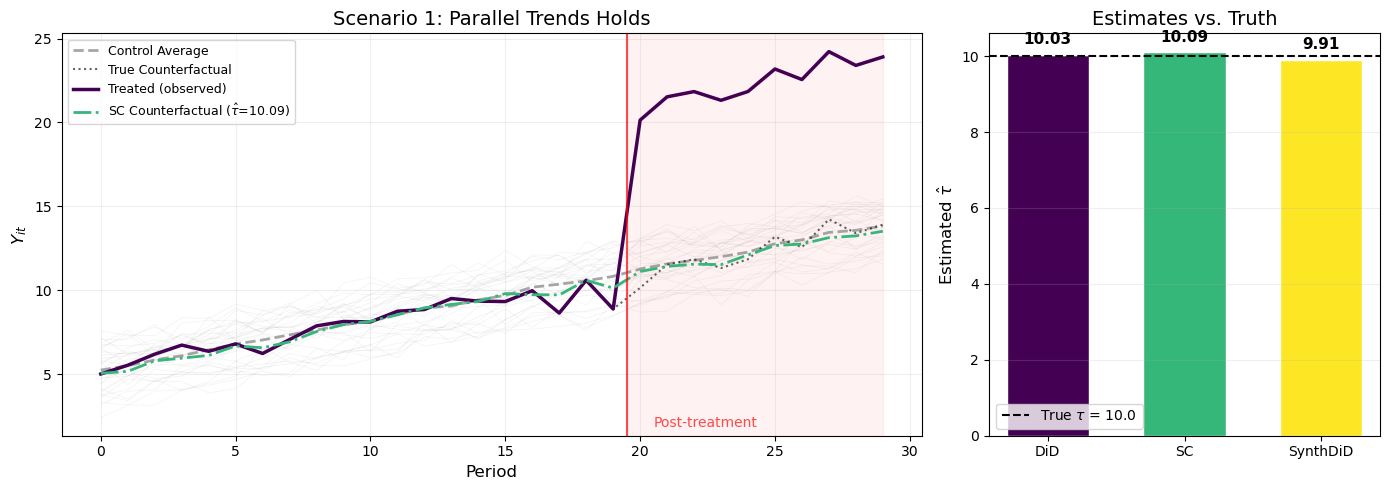

In [6]:
#| label: fig-scenario1
#| fig-cap: "Scenario 1: When parallel trends holds, all three methods closely recover the true treatment effect."
#| code-fold: true

plot_scenario(info1, results1, 'Scenario 1: Parallel Trends Holds')

As expected, when parallel trends holds, all three estimators closely recover the true treatment effect $\tau = 10$. The left panel of @fig-scenario1 shows that the treated unit's pre-treatment trajectory runs parallel to the control average — exactly the setting DiD was designed for. The SC counterfactual (green dash-dot line) tracks the true counterfactual (black dotted) closely as well.

The right panel confirms that all three estimates cluster tightly around the truth. This is the baseline: **when your assumptions are satisfied, simpler methods work just fine**.

## Scenario 2: Parallel Trends Fails (Interactive Fixed Effects)

Now we introduce **interactive fixed effects**: each unit has its own loading $\gamma_i$ on the common factor $f_t$:

$$
Y_{it}(0) = \delta_t + \alpha_i + \gamma_i \cdot f_t + \varepsilon_{it}
$$

Crucially, the treated unit's level $\alpha_{\text{tr}} = 3$ remains within the convex hull of controls ($\alpha_{\text{co}} \sim U[1, 5]$), and its factor loading $\gamma_{\text{tr}} = 2.5$ is within the range of control loadings ($\gamma_{\text{co}} \sim U[0, 3]$).

Since different units now follow different trends (depending on $\gamma_i$), parallel trends is **violated**. DiD should be biased. However, SC can construct a synthetic control that matches both the level and the factor loading of the treated unit, so it should recover the true effect.

In [7]:
# Scenario 2: Interactive FE, treated unit within convex hull
rng2 = np.random.default_rng(42)
gamma_co_2 = rng2.uniform(0, 3, 30)  # control factor loadings

df2, info2 = generate_panel(
    N_co=30, T_pre=20, T_post=10, tau=10.0,
    alpha_tr=3.0,            # within control range
    gamma_co=gamma_co_2,     # heterogeneous factor loadings
    gamma_tr=2.5,            # within control range
    sigma=0.5, seed=42,
)

results2 = estimate_all(df2, info2)

print("=" * 50)
print("Scenario 2: Interactive Fixed Effects")
print("=" * 50)
print(f"True tau:     {info2['tau']:.2f}")
print(f"DiD:          {results2['DiD']['tau']:.2f}  (bias: {results2['DiD']['tau'] - info2['tau']:+.2f})")
print(f"SC:           {results2['SC']['tau']:.2f}  (bias: {results2['SC']['tau'] - info2['tau']:+.2f})")
print(f"SynthDiD:     {results2['SynthDiD']['tau']:.2f}  (bias: {results2['SynthDiD']['tau'] - info2['tau']:+.2f})")

Scenario 2: Interactive Fixed Effects
True tau:     10.00
DiD:          12.63  (bias: +2.63)
SC:           8.91  (bias: -1.09)
SynthDiD:     9.78  (bias: -0.22)


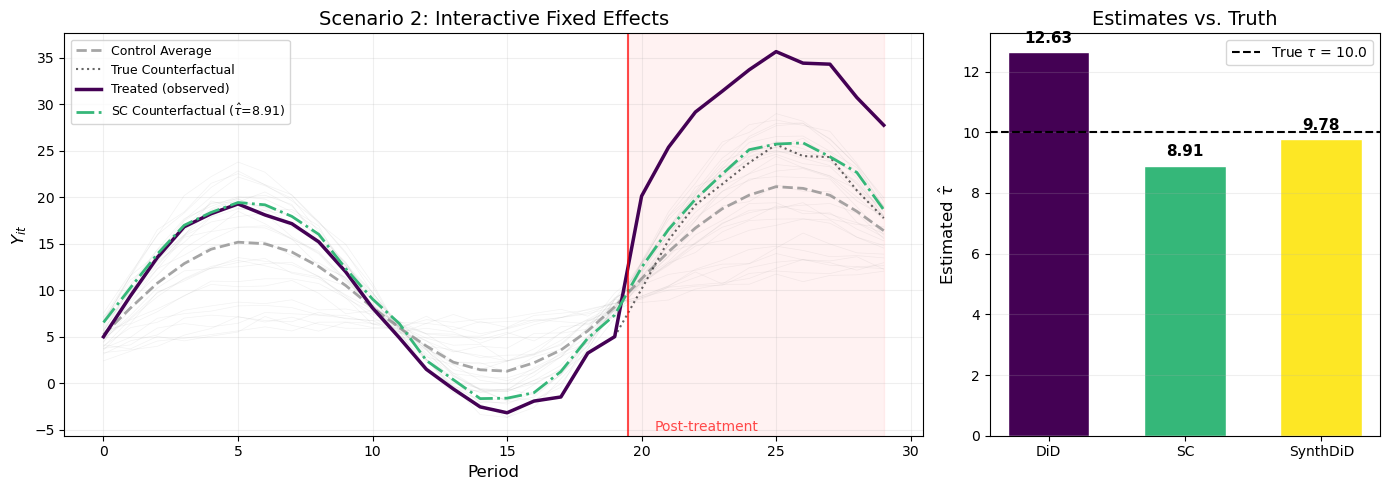

In [8]:
#| label: fig-scenario2
#| fig-cap: "Scenario 2: When parallel trends fails due to interactive fixed effects, DiD is biased while SC and SynthDiD recover the true effect."
#| code-fold: true

plot_scenario(info2, results2, 'Scenario 2: Interactive Fixed Effects')

@fig-scenario2 tells a very different story from Scenario 1. The left panel shows that the treated unit (purple) no longer runs parallel to the control average (gray dashed) in the pre-treatment period — the trajectories visibly diverge due to the interactive fixed effects. The DiD counterfactual, which projects the control average's change onto the treated unit, is therefore **biased**.

The SC counterfactual (green), by contrast, closely tracks the treated unit's true counterfactual in both the pre- and post-treatment periods. This is because SC found a weighted combination of controls that matches the treated unit's *specific* trajectory, including its factor loading.

The right panel confirms the key takeaway: **DiD is substantially biased**, while both SC and SynthDiD are close to the true $\tau = 10$. This is exactly the scenario that motivated synthetic control methods — when units follow different trends, equal-weighting all controls (as DiD does) gives the wrong answer.

## Scenario 3: Interactive FE + Level Shift

The final scenario combines interactive fixed effects with a **level shift**: the treated unit's fixed effect $\alpha_{\text{tr}} = 20$ is far above the range of any control unit ($\alpha_{\text{co}} \sim U[1, 5]$):

$$
Y_{it}(0) = \delta_t + \alpha_i + \gamma_i \cdot f_t + \varepsilon_{it}, \quad \alpha_{\text{tr}} = 20 \gg \max_i \alpha_i^{\text{co}}
$$

This creates a two-fold challenge:

- **DiD fails** because parallel trends is violated (interactive FE).
- **SC fails** because the treated unit's *level* is outside the convex hull of controls. With weights constrained to the simplex ($\omega \geq 0$, $\sum \omega = 1$), SC cannot produce a synthetic control at level 20 from units at levels 1–5. It will try to match the level by putting all weight on the highest-level control, which may not have the right factor loading.

**SynthDiD should handle both**: its unit FE $\alpha_i$ absorbs the level shift (like DiD), while the data-driven weights match the factor loading pattern (like SC).

In [9]:
# Scenario 3: Interactive FE + level shift
rng3 = np.random.default_rng(42)
gamma_co_3 = rng3.uniform(0, 3, 30)

df3, info3 = generate_panel(
    N_co=30, T_pre=20, T_post=10, tau=10.0,
    alpha_tr=20.0,           # FAR outside control range [1, 5]
    gamma_co=gamma_co_3,     # heterogeneous factor loadings
    gamma_tr=2.5,            # within control range
    sigma=0.5, seed=42,
)

results3 = estimate_all(df3, info3)

print("=" * 50)
print("Scenario 3: Interactive FE + Level Shift")
print("=" * 50)
print(f"True tau:     {info3['tau']:.2f}")
print(f"DiD:          {results3['DiD']['tau']:.2f}  (bias: {results3['DiD']['tau'] - info3['tau']:+.2f})")
print(f"SC:           {results3['SC']['tau']:.2f}  (bias: {results3['SC']['tau'] - info3['tau']:+.2f})")
print(f"SynthDiD:     {results3['SynthDiD']['tau']:.2f}  (bias: {results3['SynthDiD']['tau'] - info3['tau']:+.2f})")

Scenario 3: Interactive FE + Level Shift
True tau:     10.00
DiD:          12.63  (bias: +2.63)
SC:           23.94  (bias: +13.94)
SynthDiD:     9.78  (bias: -0.22)


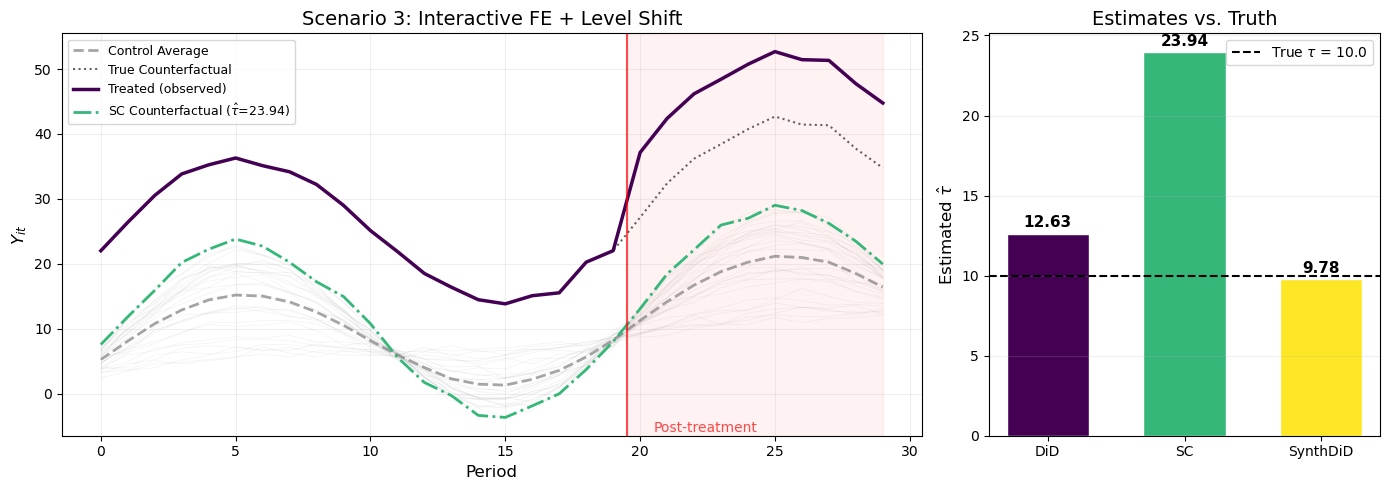

In [10]:
#| label: fig-scenario3
#| fig-cap: "Scenario 3: With both interactive fixed effects and a level shift, only SynthDiD recovers the true treatment effect."
#| code-fold: true

plot_scenario(info3, results3, 'Scenario 3: Interactive FE + Level Shift')

@fig-scenario3 illustrates the scenario where **SynthDiD shines**. The left panel shows a dramatic level gap between the treated unit (purple, at ~$Y \approx 25$) and the control units (gray, clustered around $Y \approx 5$–$12$). The SC counterfactual (green) cannot reach the treated unit's level — it is forced to stay within the convex hull of control outcomes.

The right panel makes the failure modes clear:

- **DiD** is biased by the interactive fixed effects (same issue as Scenario 2).
- **SC** is biased because the level shift distorts the weights: instead of matching the factor loading $\gamma_{\text{tr}} = 2$, SC puts all weight on the control unit with the highest level, which may have a very different $\gamma_i$.
- **SynthDiD** absorbs the level shift via its intercept (unit FE) and matches the factor loading via data-driven weights, recovering a much more accurate estimate.

This is the core insight of Arkhangelsky et al. (2021): by combining DiD's intercept adjustment with SC's data-driven weighting, SynthDiD is robust to both level shifts *and* non-parallel trends.

## Monte Carlo Comparison

The single realizations above are illustrative, but they depend on a particular draw of $\varepsilon_{it}$. To confirm that the patterns are robust, we run a small Monte Carlo experiment: 200 replications of each scenario, varying only the noise draws.

In [11]:
n_mc = 200
tau_true = 10.0

# Pre-draw fixed control loadings (same across MC runs, only noise varies)
rng_mc = np.random.default_rng(0)
gamma_co_mc = rng_mc.uniform(0, 3, 30)

scenarios = {
    'S1: Parallel Trends': {
        'alpha_tr': 3.0, 'gamma_co': np.zeros(30), 'gamma_tr': 0.0,
    },
    'S2: Interactive FE': {
        'alpha_tr': 3.0, 'gamma_co': gamma_co_mc, 'gamma_tr': 2.5,
    },
    'S3: Interactive FE\n+ Level Shift': {
        'alpha_tr': 20.0, 'gamma_co': gamma_co_mc, 'gamma_tr': 2.5,
    },
}

mc_results = {s: {m: [] for m in ['DiD', 'SC', 'SynthDiD']} for s in scenarios}

for s_name, s_params in scenarios.items():
    print(f"Running MC for {s_name}...", end=" ")
    for i in range(n_mc):
        df_mc, info_mc = generate_panel(
            N_co=30, T_pre=20, T_post=10, tau=tau_true,
            alpha_tr=s_params['alpha_tr'],
            gamma_co=s_params['gamma_co'],
            gamma_tr=s_params['gamma_tr'],
            sigma=0.5, seed=1000 + i,
        )
        
        Y_mc = info_mc['Y']
        N_co_mc = info_mc['N_co']
        T_pre_mc = info_mc['T_pre']
        
        # DiD
        tau_did, _ = estimate_did_manual(Y_mc, N_co_mc, T_pre_mc)
        mc_results[s_name]['DiD'].append(tau_did)
        
        # SC
        tau_sc, _, _ = estimate_sc_manual(Y_mc, N_co_mc, T_pre_mc)
        mc_results[s_name]['SC'].append(tau_sc)
        
        # SynthDiD
        post_periods = list(range(T_pre_mc, T_pre_mc + info_mc['T_post']))
        try:
            sdid = SyntheticDiD(seed=i)
            sdid_res = sdid.fit(
                df_mc, outcome='y', treatment='treated',
                unit='unit', time='period', post_periods=post_periods,
            )
            mc_results[s_name]['SynthDiD'].append(sdid_res.att)
        except Exception:
            mc_results[s_name]['SynthDiD'].append(np.nan)
    
    print("done.")

print("\nMonte Carlo complete.")

Running MC for S1: Parallel Trends... done.
Running MC for S2: Interactive FE... done.
Running MC for S3: Interactive FE
+ Level Shift... done.

Monte Carlo complete.


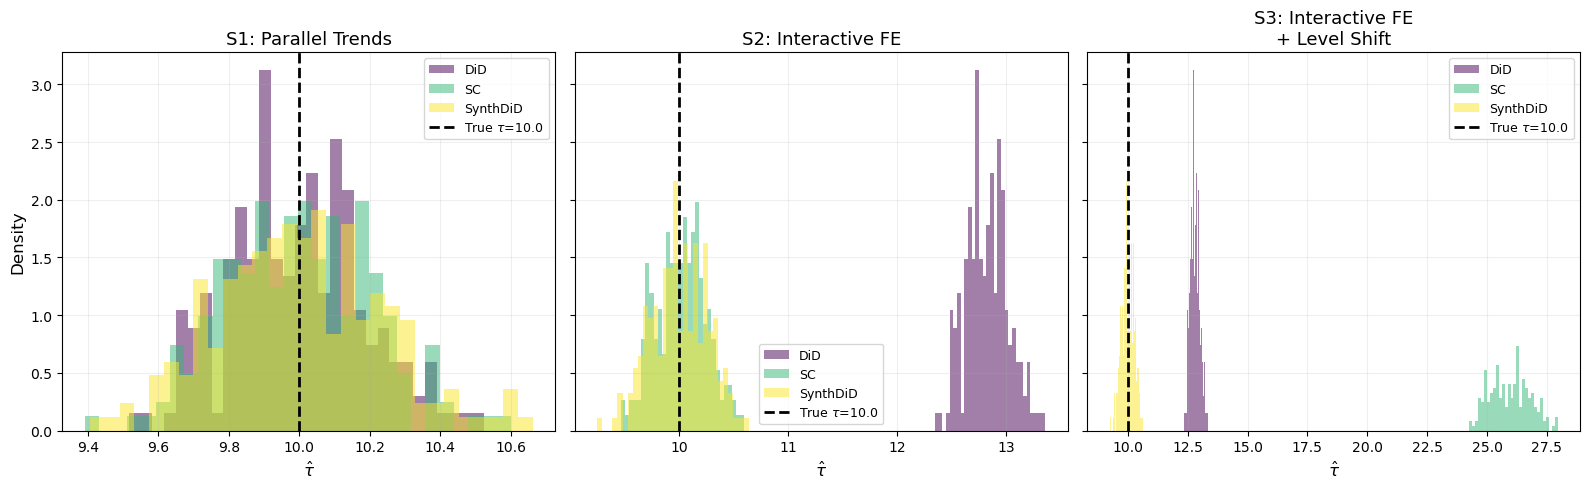

In [12]:
#| label: fig-monte-carlo
#| fig-cap: "Monte Carlo distributions of treatment effect estimates across 200 replications. The dashed black line marks the true $\\tau = 10$."
#| code-fold: true

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)
methods = ['DiD', 'SC', 'SynthDiD']
colors = {'DiD': '#440154', 'SC': '#35b779', 'SynthDiD': '#fde725'}

for ax, (s_name, s_data) in zip(axes, mc_results.items()):
    for method in methods:
        vals = np.array(s_data[method])
        vals = vals[~np.isnan(vals)]
        ax.hist(vals, bins=30, alpha=0.5, color=colors[method], label=method, density=True)
    
    ax.axvline(tau_true, color='black', linestyle='--', linewidth=2, label=f'True $\\tau$={tau_true}')
    ax.set_xlabel('$\\hat{\\tau}$', fontsize=12)
    ax.set_title(s_name, fontsize=13)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.2)

axes[0].set_ylabel('Density', fontsize=12)
plt.tight_layout()
plt.show()

In [13]:
#| label: tbl-monte-carlo
#| tbl-cap: "Monte Carlo results: Bias, RMSE, and coverage across 200 replications."

rows = []
for s_name, s_data in mc_results.items():
    for method in ['DiD', 'SC', 'SynthDiD']:
        vals = np.array(s_data[method])
        vals = vals[~np.isnan(vals)]
        bias = np.mean(vals) - tau_true
        rmse = np.sqrt(np.mean((vals - tau_true)**2))
        rows.append({
            'Scenario': s_name.replace('\n', ' '),
            'Method': method,
            'Mean $\\hat{\\tau}$': round(np.mean(vals), 3),
            'Bias': round(bias, 3),
            'RMSE': round(rmse, 3),
        })

mc_table = pd.DataFrame(rows)
mc_table = mc_table.set_index(['Scenario', 'Method'])
mc_table

Mean $\hat{\tau}$    Bias    RMSE
Scenario                         Method                                     
S1: Parallel Trends              DiD                   9.993  -0.007   0.190
                                 SC                    9.999  -0.001   0.208
                                 SynthDiD             10.004   0.004   0.232
S2: Interactive FE               DiD                  12.824   2.824   2.831
                                 SC                   10.019   0.019   0.230
                                 SynthDiD             10.005   0.005   0.255
S3: Interactive FE + Level Shift DiD                  12.824   2.824   2.831
                                 SC                   25.966  15.966  15.987
                                 SynthDiD             10.005   0.005   0.255

The Monte Carlo results in @fig-monte-carlo and @tbl-monte-carlo confirm the patterns from the single realizations:

- **Scenario 1** (Parallel Trends): All three methods are approximately unbiased. DiD has the lowest RMSE, reflecting its efficiency advantage when its assumptions hold.
- **Scenario 2** (Interactive FE): DiD shows substantial bias, while SC and SynthDiD remain well-centered at $\tau = 10$. SC has slightly lower RMSE because it doesn't need to estimate time weights.
- **Scenario 3** (Interactive FE + Level Shift): Both DiD and SC are biased — DiD due to non-parallel trends, SC due to the level shift breaking the convex hull condition. **Only SynthDiD remains approximately unbiased**, demonstrating its robustness.

The key takeaway: **SynthDiD is the only method that performs well across all three scenarios**. It is never the single best performer (DiD wins in Scenario 1, SC ties it in Scenario 2), but it is never badly biased either. This "minimax" property — avoiding the worst case rather than optimizing for the best case — is precisely the motivation of Arkhangelsky et al. (2021).

# Real-World Application

*Coming soon.* In a follow-up section, we will apply DiD, SC, and SynthDiD to a real policy evaluation dataset — comparing the estimated treatment effects and examining how the choice of method affects the conclusions.

Candidate datasets include:
- **California's Proposition 99** (tobacco tax) — the classic synthetic control application from Abadie et al. (2010)
- **German reunification** — Abadie et al. (2015)
- **Castle Doctrine laws** (available in `diff-diff` via `load_castle_doctrine()`)

# Conclusions

In this post, we compared three cornerstone methods for causal inference with aggregate data — Difference-in-Differences, Synthetic Control, and Synthetic Difference-in-Differences — through the lens of the unified framework from [Arkhangelsky et al. (2021)](https://doi.org/10.1257/aer.20190159).

Key takeaways:

1. **All three methods are special cases of a weighted TWFE regression**, differing only in their choice of unit weights $\hat{\omega}_i$ and time weights $\hat{\lambda}_t$. This unification reveals exactly *which* assumptions each method relies on.

2. **DiD is efficient when parallel trends holds** (Scenario 1), but breaks down when units follow heterogeneous trends (Scenarios 2–3). Its uniform unit weights cannot adapt to differential factor loadings.

3. **SC handles non-parallel trends** by matching the treated unit's pre-treatment trajectory (Scenario 2), but fails when a **level shift** puts the treated unit outside the convex hull of controls (Scenario 3). Without an intercept, SC tries to match levels through the weights, distorting the factor loading match.

4. **SynthDiD provides the best of both worlds**: it absorbs level shifts via unit fixed effects (like DiD) while using data-driven unit weights to match factor loadings (like SC). Additionally, its time weights focus on the most informative pre-treatment periods. As a result, it is the only method that performs well **across all three scenarios**.

5. The [`diff-diff`](https://github.com/igerber/diff-diff) Python package provides a comprehensive implementation of SynthDiD and many other modern DiD estimators, making these methods easily accessible for applied work.

# References

- Arkhangelsky, D., Athey, S., Hirshberg, D. A., Imbens, G. W., & Kellogg, S. (2021). Synthetic Difference-in-Differences. *American Economic Review*, 111(12), 4088–4118.
- Abadie, A., Diamond, A., & Hainmueller, J. (2010). Synthetic Control Methods for Comparative Case Studies: Estimating the Effect of California's Tobacco Control Program. *Journal of the American Statistical Association*, 105(490), 493–505.
- Abadie, A., Diamond, A., & Hainmueller, J. (2015). Comparative Politics and the Synthetic Control Method. *American Journal of Political Science*, 59(2), 495–510.
- Abadie, A. (2021). Using Synthetic Controls: Feasibility, Data Requirements, and Methodological Aspects. *Journal of Economic Literature*, 59(2), 391–425.
- Gerber, I. (2025). diff-diff: A comprehensive Python package for Difference-in-Differences. [GitHub](https://github.com/igerber/diff-diff).